In [123]:
import math
import random
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
import operator
import gudhi as gd
from sklearn.manifold import Isomap

In [124]:
def Extract0(lst): 
    return [item[0] for item in lst]  ### extract the first element in the sublist
def Extract1(lst): 
    return [item[1] for item in lst]  ### extract the second element in the sublist

In [125]:
def rips_filtration(data, max_edge):

    birth1_all = []
    death1_all = []

    for i in range(data.shape[0]):
        rips_complex = gd.RipsComplex(points=data[i],
                                     max_edge_length=max_edge)

        simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)

        BarCodes_Rips01 = simplex_tree.persistence()
        index = Extract0(BarCodes_Rips01).index(0) ### remove the infinity bar
        del BarCodes_Rips01[index]
    
        index = Extract0(BarCodes_Rips01).index(0) ### seperate H0 and H1
        BarCodes_Rips1 = Extract1(BarCodes_Rips01[0:index]) ### remmoving the dimension number
    
        birth1 = []
        death1 = []
        for item in BarCodes_Rips1: ### extracting birth and death for H1
            birth1.append(item[0])
            death1.append(item[1])
        birth1_all.append(birth1)
        death1_all.append(death1)
    return (birth1_all, death1_all)   

def bar_length(data, birth1_all, death1_all): ### death1_all, birth1_all are the output from filtration
    bar_length_h1 = []

    for i in range(data.shape[0]):
        bar_length = np.subtract(death1_all[i],birth1_all[i])
        bar_length_h1.append(bar_length)
        
    return(bar_length_h1)

def breakpoints(max_birth, min_birth, bin_num):  
    breakpoints_seq = np.linspace(min_birth, max_birth,(bin_num+1))
    return(breakpoints_seq)


Note: The following chunk of code is borrowed from gudhi.wasserstein (https://gudhi.inria.fr/python/latest/_modules/gudhi/wasserstein/wasserstein.html)

In [126]:
import scipy.spatial.distance as sc

try:
    import ot
except ImportError:
    print("POT (Python Optimal Transport) package is not installed. Try to run $ conda install -c conda-forge pot ; or $ pip install POT")


# Currently unused, but Théo says it is likely to be used again.
def _proj_on_diag(X):
    '''
    :param X: (n x 2) array encoding the points of a persistent diagram.
    :returns: (n x 2) array encoding the (respective orthogonal) projections of the points onto the diagonal
    '''
    Z = (X[:,0] + X[:,1]) / 2.
    return np.array([Z , Z]).T


def _dist_to_diag(X, internal_p):
    '''
    :param X: (n x 2) array encoding the points of a persistent diagram.
    :param internal_p: Ground metric (i.e. norm L^p).
    :returns: (n) array encoding the (respective orthogonal) distances of the points to the diagonal

    .. note::
        Assumes that the points are above the diagonal.
    '''
    return (X[:, 1] - X[:, 0]) * 2 ** (1.0 / internal_p - 1)


def _build_dist_matrix(X, Y, order, internal_p):
    '''
    :param X: (n x 2) numpy.array encoding the (points of the) first diagram.
    :param Y: (m x 2) numpy.array encoding the second diagram.
    :param order: exponent for the Wasserstein metric.
    :param internal_p: Ground metric (i.e. norm L^p).
    :returns: (n+1) x (m+1) np.array encoding the cost matrix C.
                For 0 <= i < n, 0 <= j < m, C[i,j] encodes the distance between X[i] and Y[j],
                while C[i, m] (resp. C[n, j]) encodes the distance (to the p) between X[i] (resp Y[j])
                and its orthogonal projection onto the diagonal.
                note also that C[n, m] = 0  (it costs nothing to move from the diagonal to the diagonal).
    '''
    Cxd = _dist_to_diag(X, internal_p)**order
    Cdy = _dist_to_diag(Y, internal_p)**order
    if np.isinf(internal_p):
        C = sc.cdist(X,Y, metric='chebyshev')**order
    else:
        C = sc.cdist(X,Y, metric='minkowski', p=internal_p)**order
    Cf = np.hstack((C, Cxd[:,None]))
    Cdy = np.append(Cdy, 0)

    Cf = np.vstack((Cf, Cdy[None,:]))

    return Cf


def _perstot_autodiff(X, order, internal_p):
    '''
    Version of _perstot that works on eagerpy tensors.
    '''
    return _dist_to_diag(X, internal_p).norms.lp(order)

def _perstot(X, order, internal_p, enable_autodiff):
    '''
    :param X: (n x 2) numpy.array (points of a given diagram).
    :param order: exponent for Wasserstein.
    :param internal_p: Ground metric on the (upper-half) plane (i.e. norm L^p in R^2).
    :param enable_autodiff: If X is torch.tensor, tensorflow.Tensor or jax.numpy.ndarray, make the computation
        transparent to automatic differentiation.
    :type enable_autodiff: bool
    :returns: float, the total persistence of the diagram (that is, its distance to the empty diagram).
    '''
    if enable_autodiff:
        import eagerpy as ep

        return _perstot_autodiff(ep.astensor(X), order, internal_p).raw
    else:
        return np.linalg.norm(_dist_to_diag(X, internal_p), ord=order)


def wasserstein_distance(X, Y, matching=False, order=1., internal_p=np.inf, enable_autodiff=False):
    '''
    :param X: (n x 2) numpy.array encoding the (finite points of the) first diagram. Must not contain essential points
                (i.e. with infinite coordinate).
    :param Y: (m x 2) numpy.array encoding the second diagram.
    :param matching: if True, computes and returns the optimal matching between X and Y, encoded as
                     a (n x 2) np.array  [...[i,j]...], meaning the i-th point in X is matched to
                     the j-th point in Y, with the convention (-1) represents the diagonal.
    :param order: exponent for Wasserstein; Default value is 1.
    :param internal_p: Ground metric on the (upper-half) plane (i.e. norm L^p in R^2);
                       Default value is `np.inf`.
    :param enable_autodiff: If X and Y are torch.tensor or tensorflow.Tensor, make the computation
        transparent to automatic differentiation. This requires the package EagerPy and is currently incompatible
        with `matching=True`.

        .. note:: This considers the function defined on the coordinates of the off-diagonal points of X and Y
            and lets the various frameworks compute its gradient. It never pulls new points from the diagonal.
    :type enable_autodiff: bool
    :returns: the Wasserstein distance of order q (1 <= q < infinity) between persistence diagrams with
              respect to the internal_p-norm as ground metric.
              If matching is set to True, also returns the optimal matching between X and Y.
    '''
    n = len(X)
    m = len(Y)

    # handle empty diagrams
    if n == 0:
        if m == 0:
            if not matching:
                # What if enable_autodiff?
                return 0.
            else:
                return 0., np.array([])
        else:
            if not matching:
                return _perstot(Y, order, internal_p, enable_autodiff)
            else:
                return _perstot(Y, order, internal_p, enable_autodiff), np.array([[-1, j] for j in range(m)])
    elif m == 0:
        if not matching:
            return _perstot(X, order, internal_p, enable_autodiff)
        else:
            return _perstot(X, order, internal_p, enable_autodiff), np.array([[i, -1] for i in range(n)])

    if enable_autodiff:
        import eagerpy as ep

        X_orig = ep.astensor(X)
        Y_orig = ep.astensor(Y)
        X = X_orig.numpy()
        Y = Y_orig.numpy()
    M = _build_dist_matrix(X, Y, order=order, internal_p=internal_p)
    a = np.ones(n+1) # weight vector of the input diagram. Uniform here.
    a[-1] = m
    b = np.ones(m+1) # weight vector of the input diagram. Uniform here.
    b[-1] = n

    if matching:
        assert not enable_autodiff, "matching and enable_autodiff are currently incompatible"
        P = ot.emd(a=a,b=b,M=M, numItermax=2000000)
        ot_cost = np.sum(np.multiply(P,M))
        P[-1, -1] = 0  # Remove matching corresponding to the diagonal
        match = np.argwhere(P)
        # Now we turn to -1 points encoding the diagonal
        match[:,0][match[:,0] >= n] = -1
        match[:,1][match[:,1] >= m] = -1
        return ot_cost ** (1./order) , match

    if enable_autodiff:
        P = ot.emd(a=a, b=b, M=M, numItermax=2000000)
        pairs_X_Y = np.argwhere(P[:-1, :-1])
        pairs_X_diag = np.nonzero(P[:-1, -1])
        pairs_Y_diag = np.nonzero(P[-1, :-1])
        dists = []
        # empty arrays are not handled properly by the helpers, so we avoid calling them
        if len(pairs_X_Y):
            dists.append((Y_orig[pairs_X_Y[:, 1]] - X_orig[pairs_X_Y[:, 0]]).norms.lp(internal_p, axis=-1).norms.lp(order))
        if len(pairs_X_diag[0]):
            dists.append(_perstot_autodiff(X_orig[pairs_X_diag], order, internal_p))
        if len(pairs_Y_diag[0]):
            dists.append(_perstot_autodiff(Y_orig[pairs_Y_diag], order, internal_p))
        dists = [dist.reshape(1) for dist in dists]
        return ep.concatenate(dists).norms.lp(order).raw
        # We can also concatenate the 3 vectors to compute just one norm.

    # Comptuation of the otcost using the ot.emd2 library.
    # Note: it is the Wasserstein distance to the power q.
    # The default numItermax=100000 is not sufficient for some examples with 5000 points, what is a good value?
    ot_cost = ot.emd2(a, b, M, numItermax=2000000)

    return ot_cost ** (1./order)


In [127]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def MMD(x, y, kernel):
    """Emprical maximum mean discrepancy. The lower the result
       the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    x = torch.from_numpy(x)
    y = torch.from_numpy(y)

    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))
    
    dxx = rx.t() + rx - 2. * xx # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy # Used for B in (1)
    dxy = rx.t() + ry - 2. * zz # Used for C in (1)
    
    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))
            
    if kernel == "rbf":
      
        bandwidth_range = [10, 15, 20, 50]
        for a in bandwidth_range:
            XX += torch.exp(-0.5*dxx/a)
            YY += torch.exp(-0.5*dyy/a)
            XY += torch.exp(-0.5*dxy/a)
    
    return torch.mean(XX + YY - 2. * XY)

In [128]:
def s(theta, t):
    x = theta[0] + theta[2] * np.cos(t)
    y = theta[1] + theta[2] * np.sin(t)
    return np.array([x, y])

In [129]:
x_pre_change = []
y_pre_change = []
pre_change = []
width = 2.8
height = 1.4
for i in range(300):
    ts = np.linspace(0, 2 * np.pi, num=100) ### 100 points sampled on circle
    cx = 0; cy = 0; r = 1; noise = 0.05 ### set the noise to be 0.05
    ss = s([cx, cy, r], ts)
    ss[0] += noise * np.random.randn(ts.shape[0]) ### uniform distribution over [0, 1)
    ss[1] += noise * np.random.randn(ts.shape[0])
    ss[0] = ss[0] * width/2.0
    ss[1] = ss[1] * height/2.0
    x_pre_change.append(ss[0])
    y_pre_change.append(ss[1])
    pre_change.append(list(zip(ss[0], ss[1])))
    
x_post_change = []
y_post_change = []
post_change = []
width = 2.8
height = 1.4
for i in range(200):
    ts = np.linspace(0, 2 * np.pi, num=100) ### 100 points sampled on circle
    cx = 0; cy = 0; r = 1; noise = 0.10 ### set the noise to be 0.05
    ss = s([cx, cy, r], ts)
    ss[0] += noise * np.random.randn(ts.shape[0]) ### uniform distribution over [0, 1)
    ss[1] += noise * np.random.randn(ts.shape[0])
    ss[0] = ss[0] * width/2.0
    ss[1] = ss[1] * height/2.0
    x_post_change.append(ss[0])
    y_post_change.append(ss[1])
    post_change.append(list(zip(ss[0], ss[1])))
    
data = pre_change+ post_change
data = np.array(data)

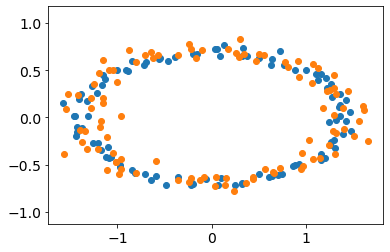

In [146]:
### Comparison of pre-change and post-change
plt.figure()
plt.axis('equal')
plt.scatter(x_pre_change[10], y_pre_change[10])
plt.scatter(x_post_change[10], y_post_change[10])
plt.show()

In [130]:
birth1_all, death1_all = rips_filtration(data, 5)
bar_length_h1 = bar_length(data, birth1_all, death1_all)

In [131]:
zip_all = []
for i in range(len(data)):
    bar_length_h1[i] = [l.tolist() for l in bar_length_h1[i]]
    zip_all.append(tuple(zip(birth1_all[i], bar_length_h1[i])))

In [132]:
points = np.array([[0.25529084, 1.08818905],
 [0.31119273, 0.92205426],
 [0.23619563, 0.01965223],
 [0.17702578, 0.01349417]])

prop_all = []
for i in range(len(zip_all)):
    point_index = []
    for j in range(len(zip_all[i])):
        point_index.append(np.argmin(np.sum((points - list(zip_all[i][j]))**2, axis=1)))
    prop = []
    for i in range(4):
        prop.append(point_index.count(i))
    prop_all.append(prop)

In [133]:
weights = [2.304165546247164, 2.0447645436778212, 2.1681953600925272, 1.702700233400409]

def stat_cal(data, bin_num, hist_all):
    m0 = 20
    m1 = 80
    stat = []

    for t in range(101, data.shape[0]):
        temp = []
        for k in range(max(t-m1, math.ceil(t/2)+1), t-m0+1):
            M = math.ceil((t-k)/2)
            pref = hist_all[t-4*M+1:t-3*M+1] ### select all histograms 
            arrays = [np.array(x) for x in pref]            
            omega = [np.mean(k) for k in zip(*arrays)] ### pooled histograms
        
            pres = hist_all[t-3*M+1:t-2*M+1] ### select all histograms 
            arrays = [np.array(x) for x in pres]            
            omega_prime = [np.mean(k) for k in zip(*arrays)] ### pooled histograms
        
            pstf = hist_all[t-2*M+1:t-M+1] ### select all histograms 
            arrays = [np.array(x) for x in pstf]            
            xi = [np.mean(k) for k in zip(*arrays)] ### pooled histograms
    
            psts = hist_all[t-M+1:t+1] ### select all histograms 
            arrays = [np.array(x) for x in psts]            
            xi_prime = [np.mean(k) for k in zip(*arrays)] ### pooled histograms
        
            res_list = [] 
     
            test_list1 = np.subtract(omega,xi).tolist()
            test_list2 = np.subtract(omega_prime,xi_prime).tolist()

            for i in range(0, bin_num): 
                res_list.append(test_list1[i] * test_list2[i] * weights[i]) 
        
            temp.append(sum(res_list))
        stat.append(max(temp))
    return(stat)

In [134]:
stat2_l2 = stat_cal(data, bin_num, prop_all)

In [135]:
from sklearn.preprocessing import StandardScaler
from numpy.linalg import inv
data_vector = []
for i in range(500):
    x = sorted(Extract0(data[i]))
    x = np.array(x)
    sort_index = np.argsort(Extract0(data[i]))
    xy = data[i][sort_index]
    vector = np.concatenate(xy)
    data_vector.append(vector)

# Standardizing the features
x = StandardScaler().fit_transform(data_vector)

from sklearn.decomposition import PCA
pca = PCA(n_components=15)
principalComponents = pca.fit_transform(x)    

ref_vector =principalComponents[0:100]
hatmu0 = np.nanmean(ref_vector, axis=0)
ref_vector = np.array(ref_vector).T
hatsigma0 = np.cov(ref_vector)

m0 = 20
stat_hotelling_drift = []
for t in range(m0, 101):
    sample_mean = np.nanmean(principalComponents[t-m0: t], axis=0)
    mean_diff = (sample_mean - hatmu0).reshape(15,1)
    stat_hotelling_drift.append(mean_diff.T.dot(inv(hatsigma0)).dot(mean_diff)[0][0])

m0 = 20
stat2_hotelling = [0]
for t in range(101, data.shape[0]):
    sample_mean = np.nanmean(principalComponents[t-m0: t], axis=0)
    mean_diff = (sample_mean - hatmu0).reshape(15,1)
    stat2_hotelling.append(max(0, stat2_hotelling[t-101] + mean_diff.T.dot(inv(hatsigma0)).dot(mean_diff)[0][0] - np.mean(stat_hotelling_drift)))

In [136]:
m0 = 20
m1 = 60
stat_mmd = []

for t in range(101, data.shape[0]):
    temp = []
    for k in range(max(t-m1, math.ceil(t/2)+1), t-m0+1):
        M = math.ceil((t-k)/2)
        pre_data = principalComponents[t-4*M+1:t-2*M+1]
        post_data = principalComponents[t-2*M+1:t+1]
        temp.append(MMD(pre_data, post_data, kernel="rbf")) 

    stat_mmd.append(max(temp)) 

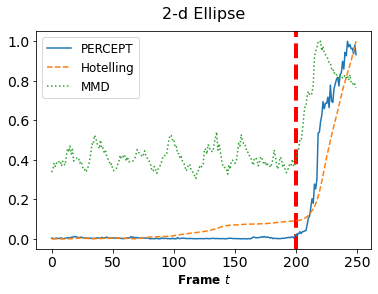

In [140]:
fig,ax = plt.subplots()
plt.axvline(x=200, color='red', linestyle='--', linewidth=4) ### the first frame in the second sequence is introduced to the point cloud
plt.plot([n/max(stat2_l2[0:250]) for n in stat2_l2[0:250]], label = "PERCEPT", lineStyle = "-")
plt.plot(stat2_hotelling[0:250]/max(stat2_hotelling[0:250]), label = "Hotelling", lineStyle = "--")
plt.plot([n/max(stat_mmd[0:250]) for n in stat_mmd[0:250]], label = "MMD", lineStyle = ":")

# set x-axis label
ax.set_xlabel('Frame $t$',fontweight='bold',fontsize=12)
plt.title("2-d Ellipse", y=1.03, fontsize = 16)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
plt.legend(fontsize = 12)
plt.show()

In [138]:
### Gel's method
birth_death1 = []
for i in range(len(birth1_all)):
    birth_death1.append([[x, y] for x, y in zip(birth1_all[i], death1_all[i])])

wd_all = []
for i in range(499):
    pd_a = np.array(birth_death1[i])
    pd_b = np.array(birth_death1[i+1])
    wd = wasserstein_distance(pd_a, pd_b, order=1, internal_p=2)
    wd_all.append(wd)

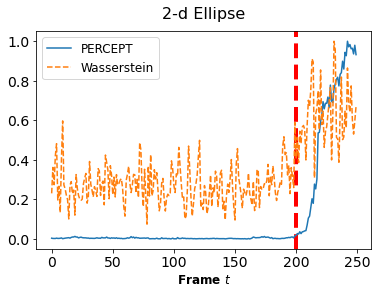

In [139]:
fig,ax = plt.subplots()
plt.axvline(x=200, color='red', linestyle='--', linewidth=4) 
plt.plot([n/max(stat2_l2[0:250]) for n in stat2_l2[0:250]], label = "PERCEPT", lineStyle = "-")
plt.plot([n/max(wd_all[100:350]) for n in wd_all[100:350]], label = "Wasserstein", lineStyle = "--")

# set x-axis label
ax.set_xlabel('Frame $t$',fontweight='bold',fontsize=12)
plt.title("2-d Ellipse", y=1.03, fontsize=16)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
plt.legend(fontsize = 12)
plt.show()